In [5]:
%matplotlib widget
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as spio
import cv2
from numpy.linalg import det, inv
import matplotlib.image as mpimg
from matplotlib.widgets import PolygonSelector
from PIL import Image

plt.style.use('default')

Task1

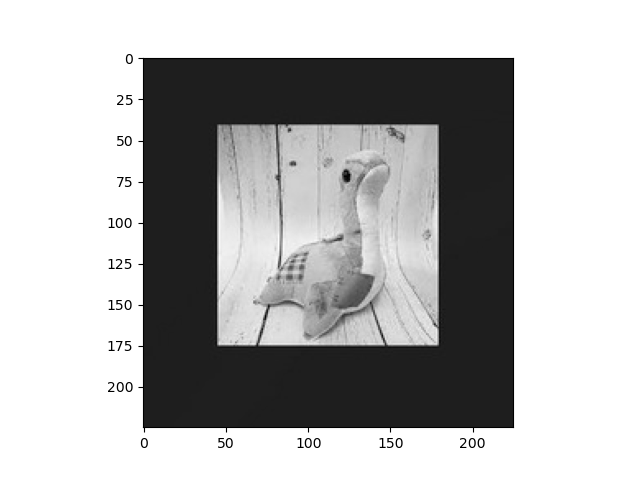

Polygon vertices:
[(47.348847624543396, 135.25486827206302), (137.446250221946, 54.28895918115393), (174.58099048168626, 110.90421892141367), (124.6621593128551, 175.43343970063447), (57.69787359856937, 164.47564749284223)]


In [6]:
source_img_path = "InputImgs\\SrcImg.png"
target_img_path = "InputImgs\\DstImg.png"
source_img_grey = cv2.imread(source_img_path, cv2.IMREAD_GRAYSCALE)
target_img_grey = cv2.imread(target_img_path, cv2.IMREAD_GRAYSCALE)
source_img = cv2.imread(source_img_path, cv2.IMREAD_COLOR)
target_img = cv2.imread(target_img_path, cv2.IMREAD_COLOR)
#source_img = cv2.cvtColor(source_img, cv2.COLOR_BGR2RGB)
#target_img_ = cv2.cvtColor(target_img, cv2.COLOR_BGR2RGB)


img_array = source_img_grey.copy()

# 回调函数，当选择完成时调用
def onselect(verts):
    global polygon
    polygon = [(y, x) for x, y in verts]
    print("Polygon vertices:")
    print(polygon)
    # 这里可以添加代码来处理多边形的顶点

# 创建图像和轴
fig, ax = plt.subplots()
ax.imshow(img_array, cmap='gray')

# 创建PolygonSelector实例
polygon_selector = PolygonSelector(ax, onselect)

# 显示图像并开始多边形选择过程
plt.show()

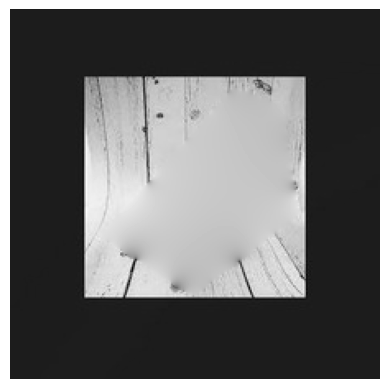

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt
from skimage import io
from skimage.draw import polygon2mask
from scipy.sparse.linalg import spsolve
from scipy.sparse import lil_matrix
from skimage.color import rgb2gray

gray_image = source_img_grey.copy()  # 转换为灰度图像

# 获取图像尺寸
image_height, image_width = gray_image.shape[:2]
# 创建多边形掩码
mask = polygon2mask((image_height, image_width), polygon)

# 获取多边形内部的像素索引
interior_idx = np.argwhere(mask)

# 初始化稀疏矩阵A和向量b
n_interior_pixels = len(interior_idx)
A = lil_matrix((n_interior_pixels, n_interior_pixels), dtype=float)
b = np.zeros(n_interior_pixels)

# 构建线性系统
for i, (row, col) in enumerate(interior_idx):
    A[i, i] = 4  # 主对角线元素
    for drow, dcol in [(-1, 0), (1, 0), (0, -1), (0, 1)]:  # 四个方向的邻居
        neighbor = (row + drow, col + dcol)
        if mask[neighbor]:  # 如果邻居在内部
            j = np.argwhere(np.all(interior_idx == neighbor, axis=1))[0, 0]
            A[i, j] = -1
        else:
            # 如果邻居在边界上或者在掩码外面，我们需要从源图像中获取对应的强度值
            b[i] += gray_image[neighbor]

# 将A矩阵转换为CSR格式
A_csr = A.tocsr()

# 求解线性系统
solution = spsolve(A_csr, b)

# 将解填充回图像的相应区域
for (solution_value, (row, col)) in zip(solution, interior_idx):
    # print(row, col)
    gray_image[row, col] = solution_value

# 显示填充后的图像
plt.imshow(gray_image, cmap='gray')
plt.axis('off')
plt.show()

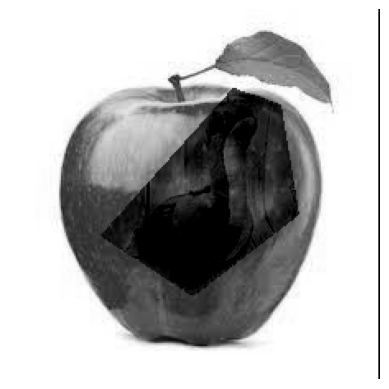

array([[255, 255, 255, ..., 255, 255,   0],
       [255, 255, 255, ..., 255, 255,   0],
       [255, 255, 255, ..., 255, 255,   0],
       ...,
       [255, 255, 255, ..., 255, 255,   0],
       [255, 255, 255, ..., 255, 255,   0],
       [255, 255, 255, ..., 255, 255,   0]], dtype=uint8)

In [32]:
from scipy import signal, sparse
import numpy as np
from scipy.sparse.linalg import spsolve
from matplotlib import pyplot as plt

source_img_path = "InputImgs\\SrcImg.png"
target_img_path = "InputImgs\\DstImg.png"
# source_img_path = "InputImgs\\1.png"
# target_img_path = "InputImgs\\2.png"
source_img = Image.open(source_img_path).convert('L')
target_img = Image.open(target_img_path).convert('L')
source_img_array = np.array(source_img, dtype=np.uint8)
target_img_array = np.array(target_img, dtype=np.uint8)

def compute_gradients(img):
    """Compute gradients of the image using forward differencing."""
    gx = np.roll(img, -1, axis=1) - img
    gy = np.roll(img, -1, axis=0) - img
    return gx, gy

def seamless_cloning(source_img, target_img, mask, polygon, mode='importing'):
    # 创建拉普拉斯算子
    laplacian = np.array([[0, 1, 0], [1, -4, 1], [0, 1, 0]])
    # 计算源图像的拉普拉斯算子
    grad_source = signal.convolve2d(source_img, laplacian, mode='same', boundary='fill', fillvalue=0)
    grad_target = signal.convolve2d(target_img, laplacian, mode='same', boundary='fill', fillvalue=0)
    # 获取掩码内的索引
    idx = np.argwhere(mask)
    
    # 创建系数矩阵A和向量b
    n_pixels = len(idx)
    A = lil_matrix((n_pixels, n_pixels))
    b = np.zeros(n_pixels)
    
    for i, (row, col) in enumerate(idx):
        A[i, i] = 4
        neighbors = [(row-1, col), (row+1, col), (row, col-1), (row, col+1)]
        neighbor_indices = []

        # 首先检查所有邻居
        for neighbor in neighbors:
            if (0 <= neighbor[0] < mask.shape[0]) and (0 <= neighbor[1] < mask.shape[1]):
                if mask[neighbor]:
                    # 邻居在掩码内，我们记录下这个邻居的索引，稍后处理
                    j = np.argwhere((idx == neighbor).all(axis=1))
                    if j.size > 0:
                        neighbor_indices.append(j[0][0])
                else:
                    # 如果有邻居不在掩码内，当前像素为边缘像素
                    b[i] = target_img[row, col]
                    neighbor_indices = []  # 清空之前记录的邻居索引
                    break  # 不需要进一步检查其他邻居
        
        # 如果当前像素不是边缘像素，则处理邻居索引
        for neighbor_idx in neighbor_indices:
            A[i, neighbor_idx] = -1
    
        # 如果当前点不是边缘点，那么我们需要根据模式来使用梯度
        if A[i, i] == 4:
            # 在导入模式下使用源图像的梯度
            if mode == 'importing':
                b[i] -= grad_source[row, col]
            # 在混合模式下比较源图像和目标图像的梯度
            elif mode == 'mixing':
                if abs(grad_source[row, col]) > abs(grad_target[row, col]):
                    b[i] -= grad_source[row, col]
                else:
                    b[i] -= grad_target[row, col]
    
    # 解线性方程组
    solution = spsolve(A.tocsr(), b)
    #solution = np.round(solution).astype(np.uint8)

    # 创建一个新的目标图像以填充结果
    cloned_img = target_img.copy()
    for (row, col), value in zip(idx, solution):
        cloned_img[row, col] = np.clip(value, 0, 255)

    plt.imshow(cloned_img, cmap='gray')
    plt.axis('off')
    plt.show()
    return cloned_img

# 使用导入梯度
# seamless_cloning(source_img_array, target_img_array, mask, polygon, mode='importing')
seamless_cloning(source_img_array, target_img_array, mask, polygon, mode='mixing')

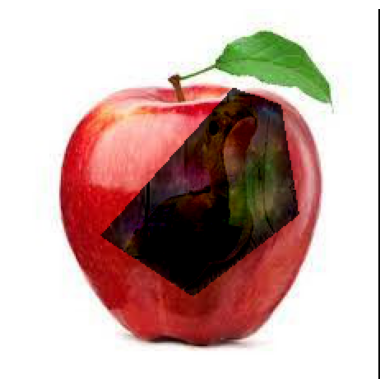

In [41]:
from PIL import Image
from scipy import signal, sparse
import numpy as np
from scipy.sparse.linalg import spsolve
from matplotlib import pyplot as plt

def compute_gradients(img):
    """Compute gradients of the image using forward differencing."""
    gx = np.roll(img, -1, axis=1) - img
    gy = np.roll(img, -1, axis=0) - img
    return gx, gy

def seamless_cloning(source_img, target_img, mask, mode='importing'):
    cloned_img = np.empty_like(target_img)
    for channel in range(3):
        source_channel = source_img[:,:,channel]
        target_channel = target_img[:,:,channel]

        # Compute Laplacian
        laplacian = np.array([[0, 1, 0], [1, -4, 1], [0, 1, 0]])
        grad_source = signal.convolve2d(source_channel, laplacian, mode='same', boundary='fill', fillvalue=0)
        grad_target = signal.convolve2d(target_channel, laplacian, mode='same', boundary='fill', fillvalue=0)

        # Get mask indices
        idx = np.argwhere(mask)

        # Create coefficient matrix A and vector b
        n_pixels = len(idx)
        A = sparse.lil_matrix((n_pixels, n_pixels))
        b = np.zeros(n_pixels)

        for i, (row, col) in enumerate(idx):
            A[i, i] = 4
            neighbors = [(row-1, col), (row+1, col), (row, col-1), (row, col+1)]
            neighbor_indices = []

            # 首先检查所有邻居
            for neighbor in neighbors:
                if (0 <= neighbor[0] < mask.shape[0]) and (0 <= neighbor[1] < mask.shape[1]):
                    if mask[neighbor]:
                        # 邻居在掩码内，我们记录下这个邻居的索引，稍后处理
                        j = np.argwhere((idx == neighbor).all(axis=1))
                        if j.size > 0:
                            neighbor_indices.append(j[0][0])
                    else:
                        # 如果有邻居不在掩码内，当前像素为边缘像素
                        b[i] = target_channel[row, col]
                        neighbor_indices = []  # 清空之前记录的邻居索引
                        break  # 不需要进一步检查其他邻居
            
            # 如果当前像素不是边缘像素，则处理邻居索引
            for neighbor_idx in neighbor_indices:
                A[i, neighbor_idx] = -1
        
            # 如果当前点不是边缘点，那么我们需要根据模式来使用梯度
            if A[i, i] == 4:
                # 在导入模式下使用源图像的梯度
                if mode == 'importing':
                    b[i] -= grad_source[row, col]
                # 在混合模式下比较源图像和目标图像的梯度
                elif mode == 'mixing':
                    if abs(grad_source[row, col]) > abs(grad_target[row, col]):
                        b[i] -= grad_source[row, col]
                    else:
                        b[i] -= grad_target[row, col]

        # Solve linear system
        solution = spsolve(A.tocsr(), b)

        # Fill in the cloned image
        channel_cloned = target_channel.copy()
        for (row, col), value in zip(idx, solution):
            channel_cloned[row, col] = np.clip(value, 0, 255)
        cloned_img[:,:,channel] = channel_cloned

    return cloned_img


source_img_path = "InputImgs\\SrcImg.png"
target_img_path = "InputImgs\\DstImg.png"
source_img = cv2.imread(source_img_path, cv2.IMREAD_COLOR)
target_img = cv2.imread(target_img_path, cv2.IMREAD_COLOR)


# 使用导入梯度
#result = seamless_cloning(source_img, target_img, mask.astype(bool), mode='importing')
result = seamless_cloning(source_img, target_img, mask.astype(bool), mode='mixing')

# 展示结果
plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

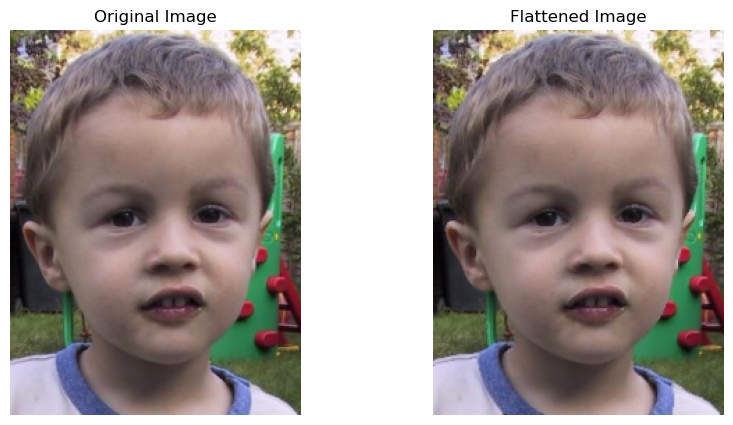

In [404]:
import numpy as np
import cv2
from scipy.sparse import lil_matrix
from scipy.sparse.linalg import spsolve
import matplotlib.pyplot as plt

# 定义边缘检测函数
def detect_edges(image):
    """使用Canny边缘检测算子生成二值掩码"""
    return cv2.Canny(image, 150, 160).astype(bool)

# 定义计算梯度函数
def compute_gradients(image):
    """计算图像的梯度"""
    gx, gy = np.gradient(image.astype(float), axis=(1, 0))
    return gx, gy

# 定义泊松求解器函数
def poisson_solver(gx, gy, mask, target_shape, image_channel):
    h, w = target_shape
    A = lil_matrix((h*w, h*w))
    b = np.zeros((h*w,))
    
    for y in range(h):
        for x in range(w):
            idx = x + y * w
            if mask[y, x]:  # 在掩码内部
                if y > 0:
                    A[idx, idx-w] = -1
                if y < h-1:
                    A[idx, idx+w] = -1
                if x > 0:
                    A[idx, idx-1] = -1
                if x < w-1:
                    A[idx, idx+1] = -1
                
                A[idx, idx] = 4
                b[idx] = gx[y, x] + gy[y, x]
            else:  # 在边界上
                A[idx, idx] = 1
                b[idx] = image_channel[y, x]

    A = A.tocsr()
    flat_channel = spsolve(A, b)
    return flat_channel.reshape(target_shape)

# 定义纹理平坦化函数
def texture_flattening(image):
    mask = detect_edges(image).astype(float)  # 将布尔掩码转换为浮点数
    flat_img = np.zeros_like(image)
    
    for channel in range(3):
        gx, gy = compute_gradients(image[:, :, channel])
        flat_img[:, :, channel] = poisson_solver(gx, gy, mask, image.shape[:2], image[:, :, channel])
    
    flat_img = np.clip(flat_img, 0, 255).astype('uint8')
    return flat_img


# 应用纹理平坦化
img_path = "InputImgs//qwe.png"
image = cv2.imread(img_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
flat_img = texture_flattening(image)

# 展示原始图像和平坦化后的图像
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(image)
axes[0].set_title('Original Image')
axes[0].axis('off')

axes[1].imshow(flat_img)
axes[1].set_title('Flattened Image')
axes[1].axis('off')

plt.show()
